In [4]:
import gc
from pathlib import Path

import numpy as np
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
from radiomics import featureextractor
from scipy.ndimage import binary_fill_holes

In [5]:
params = "../params.yml"
extractor = featureextractor.RadiomicsFeatureExtractor(params)

In [6]:
bolus_path = Path('/Volumes/TOSHIBA EXT/Animal Data/Bolus')
molecular_path = Path('/Volumes/TOSHIBA EXT/Animal Data/Paramaps')

In [7]:
bolus_mice = []
for mouse in bolus_path.iterdir():
    if mouse.is_dir():
        bolus_mice.append(mouse.name)

molecular_mice = []
for folder in molecular_path.iterdir():
    if folder.is_dir():
        for mouse in folder.iterdir():
            if mouse.name.startswith("m"):
                molecular_mice.append(mouse.name[:4])
molecular_mice = list(set(molecular_mice))

In [8]:
overlapping_mice = []
for mouse in bolus_mice:
    if mouse in molecular_mice:
        overlapping_mice.append(mouse)

len(overlapping_mice)

28

In [17]:
import yaml
import pandas as pd

yaml_path = Path('bolus-organization.yml')
data_organization = yaml.safe_load(yaml_path.read_text())

In [40]:
scan_features = {}
for mouse in tqdm(overlapping_mice[13:]):
    print(mouse)
    group = data_organization[mouse]
    
    bolus_img_folder = bolus_path / mouse
    molecular_group = (group[:2] + "Molecular" + group[2:])
    molecular_img_folder = molecular_path / molecular_group
    mouse_maps = list(molecular_img_folder.glob(f"{mouse}*"))
    mouse_scans = set([file.name[:13] for file in mouse_maps])
    
    scan_features[mouse] = {}
    scan_features[mouse]["bolus"] = {}
    scan_features[mouse]["molecular"] = {}
    
    for scan in mouse_scans:
        scan_features[mouse]["bolus"][scan] = {}
        scan_features[mouse]["molecular"][scan] = {}
        
        molecular_img_paths = list(molecular_img_folder.glob(f"{scan}*.nii"))
        bolus_img_paths = [path for path in (bolus_path / mouse).iterdir() if path.name.startswith(scan) and path.name.endswith(".nii") and "4D" not in path.name]
        
        for path in molecular_img_paths:
            molecular_img_arr = nib.load(path).get_fdata()
            molecular_img = sitk.GetImageFromArray(molecular_img_arr)
            if np.amin(molecular_img_arr) > 0:
                print(f"Warning: {path.name} has nonzero background. Value is {np.amin(molecular_img_arr)}")
                molecular_img_arr = molecular_img_arr - np.amin(molecular_img_arr)
            if np.amax(molecular_img_arr) <= 0:
                print(f"Warning: {path.name} has no positive values. Max val is {np.amax(molecular_img_arr)}")
                print("Flipping image...")
                molecular_img_arr = np.abs(molecular_img_arr)
                
            mask = (molecular_img_arr > 0).astype(np.uint8)
            final_mask = np.zeros_like(mask)
            for i in range(molecular_img_arr.shape[1]):
                final_mask[:, i, :] = binary_fill_holes(mask[:, i, :]).astype(np.uint8)
            
            assert np.amax(final_mask) == 1 and np.amin(final_mask) == 0
            mask = sitk.GetImageFromArray(final_mask)
            
            radiomics_features = extractor.execute(molecular_img, mask)
            scan_features[mouse]["molecular"][scan][path.name[13:-4]] = radiomics_features
            del molecular_img_arr, molecular_img, radiomics_features, mask, final_mask

        gc.collect()

        for path in bolus_img_paths:
            bolus_img_arr = nib.load(path).get_fdata()
            if "AUC" in path.name:
                bolus_img_arr = np.clip(bolus_img_arr, 0, 10000)
                print("Clipping AUC...")
            bolus_img = sitk.GetImageFromArray(bolus_img_arr)
            if np.amin(bolus_img_arr) > 0:
                print(f"Warning: {path.name} has nonzero background. Value is {np.amin(bolus_img_arr)}")
                bolus_img_arr = bolus_img_arr - np.amin(bolus_img_arr)
            if np.amax(bolus_img_arr) <= 0:
                print(f"Warning: {path.name} has no positive values. Max val is {np.amax(bolus_img_arr)}")
                print("Flipping image...")
                bolus_img_arr = np.abs(bolus_img_arr)
                
            mask = (bolus_img_arr > 0).astype(np.uint8)
            final_mask = np.zeros_like(mask)
            for i in range(bolus_img_arr.shape[1]):
                final_mask[:, i, :] = binary_fill_holes(mask[:, i, :]).astype(np.uint8)
            for i in range(bolus_img_arr.shape[1]):
                final_mask[:, i, :] = binary_fill_holes(final_mask[:, i, :]).astype(np.uint8)
            for i in range(bolus_img_arr.shape[2]):
                final_mask[:, :, i] = binary_fill_holes(final_mask[:, :, i]).astype(np.uint8)
            
            assert np.amax(final_mask) == 1 and np.amin(final_mask) == 0
            mask = sitk.GetImageFromArray(final_mask)
            
            try:
                radiomics_features = extractor.execute(bolus_img, mask)
            except IndexError as e:
                print(f"Error processing {path.name}: {e}")
                print("Skipping this image...")
                radiomics_features = {}
            scan_features[mouse]["bolus"][scan][path.name[13:-4]] = radiomics_features
            del bolus_img, bolus_img_arr, mask, radiomics_features, final_mask
        gc.collect()
            

  0%|          | 0/15 [00:00<?, ?it/s]

m948


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Clipping AUC...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Flipping image...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Clipping AUC...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Flipping image...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Clipping AUC...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Flipping image...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Clipping AUC...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Flipping image...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Clipping AUC...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Flipping image...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Error processing m948d20150726BolusPE.nii: Calculation of GLCM Failed.
Skipping this image...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  7%|▋         | 1/15 [04:33<1:03:48, 273.47s/it]

m924


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Clipping AUC...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Flipping image...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Clipping AUC...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Flipping image...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


: 

: 

In [31]:
scan_features['m948']['molecular'].keys()

dict_keys(['m948d20150723', 'm948d20150802', 'm948d20150724', 'm948d20150726'])

In [33]:
len(scan_features['m948']['molecular']['m948d20150724'].keys()), len(scan_features['m948']['molecular']['m948d20150726'].keys())

(11, 11)

In [34]:
import pickle
with open('organized_scan_features.pkl', 'wb') as f:
    pickle.dump(scan_features, f)

In [2]:
import pickle
with open('organized_scan_features.pkl', 'rb') as f:
    scan_features_2 = pickle.load(f)

In [ ]:
len(scan_features_2.keys())

14

In [13]:
scan_features_2.keys()

dict_keys(['m904', 'm907', 'm908', 'm913', 'm925', 'm933', 'm935', 'm937', 'm939', 'm940', 'm943', 'm946', 'm947', 'm948'])

In [29]:
scan_features_2['m948']['bolus'].keys()

dict_keys(['m948d20150723', 'm948d20150802', 'm948d20150724', 'm948d20150726'])

In [37]:
scan_features_2['m948']['bolus']['m948d20150726'].keys()

dict_keys(['BolusAIP', 'BolusAUC', 'BolusAvgDiff', 'BolusMaxDiff', 'BolusMinDiff', 'BolusMIP', 'BolusMTT'])

In [18]:
import nibabel as nib

path = '/Volumes/TOSHIBA EXT/Animal Data/Bolus/m904/m904d20150417BolusAvgDiff.nii'

data = nib.load(path).get_fdata()

In [19]:
data.shape

(130, 105, 170)

In [20]:
np.amax(data), np.amin(data)

(np.float64(38.77855434049778), np.float64(-0.17228280542776137))

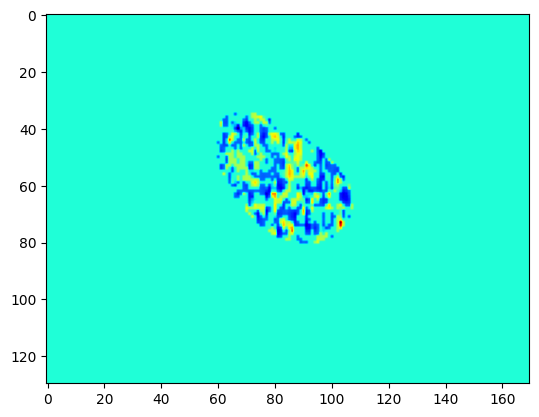

In [21]:
plt.imshow(data[:, 50, :], cmap='jet')

In [38]:
import matplotlib.pyplot as plt

In [39]:
mask = (data > 0).astype(np.uint8)
final_mask = np.zeros_like(mask)
for i in range(data.shape[0]):
    final_mask[i, :, :] = binary_fill_holes(mask[i, :, :]).astype(np.uint8)
for i in range(data.shape[1]):
    final_mask[:, i, :] = binary_fill_holes(final_mask[:, i, :]).astype(np.uint8)
for i in range(data.shape[2]):
    final_mask[:, :, i] = binary_fill_holes(final_mask[:, :, i]).astype(np.uint8)

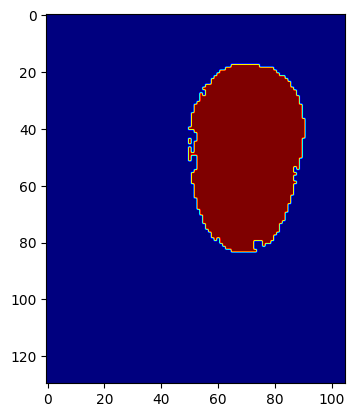

In [40]:
plt.imshow(final_mask[:, :, 60], cmap="jet")

In [41]:
import logging
logging.basicConfig(level=logging.DEBUG)

extractor.execute(sitk.GetImageFromArray(data), sitk.GetImageFromArray(final_mask))

INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing ngtdm


OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '2.1.3'),
             ('diagnostics_Versions_SimpleITK', '2.4.0'),
             ('diagnostics_Versions_PyWavelet', '1.7.0'),
             ('diagnostics_Versions_Python', '3.11.6'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True,
               'binWidth': 90,
               'weightingNorm': None}),
             ('diagnostics_Confi